In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(gtotallengths,mtotallengths, num_gconnections, num_mconnections):    
    if num_mconnections == 2 and num_gconnections ==3:# and num_mconnections==4: #gtotallengths>48
        return "t"
    elif num_mconnections == 3 and num_gconnections ==2:# and num_mconnections == 4:
        return "c"
    else:
        return "ucf"
    
def connect(cv, radius, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_d = vector_dist(cv, cv2)
        total_separations += vector_d
        if vector_d <= 2*radius and vector_d > .2*radius: # blob centers closer than diameter of one blob
            num_connections += 1
        else:
            pass
        if vector_d <= 4*radius: 
            normalized_dists.append(vector_d/(2*norm_radius))
    return (num_connections, normalized_dists, total_separations)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
connect_test = connect((0, 0),2, [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

(1, [0.1, 0.1414213562373095, 0.0], 19.97056274847714) [5.0, 10.0] hello


In [4]:
grp1 = [1, [95, 67], 2]
grp2 = [2, [9.0], 13]
print(grp1+grp2)
print([grp1[i]+grp2[i] for i in range(len(grp1))])

[1, [95, 67], 2, 2, [9.0], 13]
[3, [95, 67, 9.0], 15]


In [5]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    g_bond = 15*1.15
    m_bond = 15*1.35
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        
        phighlight = morphology.binary_opening(thresh_img, square(14))
        img = np.copy(frame)
        img[phighlight==0] = 0
        pblobs =skimage.feature.blob_doh(img, min_sigma = 10, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.6)
        
        ghighlight = morphology.opening(
        morphology.white_tophat(gaussian(thresh_img, sigma=0.2), square(14)),
                                   disk(4))
        
        img = np.copy(frame)
        img[ghighlight==0] = 0
        gblobs =skimage.feature.blob_doh(img, min_sigma = 8, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.5)
    
        
        blobset.append([pblobs, gblobs])
        ngblobs = len(gblobs)
        npblobs = len(pblobs) 
        num_blobs = ngblobs + npblobs  
        
        plas_on_glas_dists =[connect((pblob[1], pblob[0]),m_bond, gblobs) for pblob in pblobs]
        plas_on_glas_dists = [sum([pog[0] for pog in plas_on_glas_dists]), 
                              list(chain(*[pog[1] for pog in plas_on_glas_dists])),
                             sum([pog[2] for pog in plas_on_glas_dists])]
        num_mconnections = plas_on_glas_dists[0]
        mdistances = plas_on_glas_dists[1]
        mtotallengths = plas_on_glas_dists[2]
        
        glas_on_glas_dists =[connect((gblobs[i][1], gblobs[i][0]),g_bond, gblobs[i+1:]) for i in range(ngblobs-1)]
        glas_on_glas_dists = [sum([gog[0] for gog in glas_on_glas_dists]), 
                              list(chain(*[gog[1] for gog in glas_on_glas_dists])),
                             sum([gog[2] for gog in glas_on_glas_dists])]
        num_gconnections = glas_on_glas_dists[0]
        gdistances = glas_on_glas_dists[1]
        gtotallengths = glas_on_glas_dists[2]
        
        
        
        num_connections = sum([num_gconnections,num_mconnections])
        distances = list(chain(gdistances, mdistances))       
        totallengths = sum([ gtotallengths, mtotallengths])
        
        #----------------------filter------------------------- can use actual filter
        properties = {'num_blobs':num_blobs,
                      'num_pblobs':npblobs,
                      'num_gblobs':ngblobs,
                      'num_connections': num_connections,
                      'num_gconnections':num_gconnections, 
                      'num_mconnections':num_mconnections,
                     'totallengths':totallengths,  
                      'gtotallengths':gtotallengths, 
                      'mtotallengths':mtotallengths,
                     'distances':distances, 
                      'gdistances':gdistances, 
                      'mdistances':mdistances}
        #print(properties)
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = True
        if test: 
            #-----------------------------classify pt 1---------------------------------------
            clas = sideify(gtotallengths,mtotallengths,num_gconnections, num_mconnections )
            filtrate_prop.append(properties)
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






In [6]:
filenames = glob("./tchakamau/Wa*glass/*_0.avi")+glob("./tchakamau/Wa*glass/*11.avi")#glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 4
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames = {"t" : list(range(9339, 9000, -2)),
                  "c" :list(range(16462, 15973, -3)), 
                 "broken" :list(range(15961, 15800, -1)) ,
                 "odd_s" :list(chain(range(3435,3429, -1), range(13826, 13815, -1))) }
phantom_frames_2 = {"t" : list(range(17281, 16960,-2)),
                  "c" :list(range(21099,19902, -8 )), 
                 "broken" :list(range(18715, 18567, -1)) ,
                 "odd_s" :[] }
"""phantom_frames_3 = {"t" :list(range(30104, 29591, -1)),
                  "c" :list(range(30816, 30375, -2)), 
                 "broken" :list(range(30340, 30288, -1)) ,
                 "odd_s" :[]}"""
phantom_frame_sets = [phantom_frames,phantom_frames_2]
trigger_frames = [16462, 21099]#[13268, 18192, 2964, 8535]



['./tchakamau\\Washed15vglass\\45660_15Vpp_0.avi', './tchakamau\\Washed15vglass\\45660_15Vpp_11.avi']


In [7]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["t", "c", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if tf-frameindex in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], tf-frameindex))
           
        frameindex += 1
    
    
""" for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        
        frames = 
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])
"""

<generator object vreader at 0x0000023B7BD0DD68>
<generator object vreader at 0x0000023B77012318>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

In [8]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i])
    fil = len(x[0])
    pas = len(x[1])
    print(orig, fil, pas)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", pas*100/orig)
        p_rats.append(pas*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

331 331 241
t _vid
original_vid:  331
filtrate:  331
pass ratio:  72.809667673716


313 313 257
c _vid
original_vid:  313
filtrate:  313
pass ratio:  82.10862619808307


17 17 12
odd_s _vid
original_vid:  17
filtrate:  17
pass ratio:  70.58823529411765


309 309 309
broken _vid
original_vid:  309
filtrate:  309
pass ratio:  100.0


4 4 4


In [9]:
names = {'num_blobs':[],
                      'num_pblobs':[],
                      'num_gblobs':[],
                      'num_connections': [],
                      'num_gconnections':[], 
                      'num_mconnections':[],
                     'totallengths':[],  
                      'gtotallengths':[], 
                      'mtotallengths':[],
                     'distances':[],  
                      'gdistances':[], 
                      'mdistances':[]}
strings = names.keys()
distances = [string for string in strings if 'distances' in string]
simplenames = strings - distances
print(distances, simplenames)

['distances', 'gdistances', 'mdistances'] {'num_pblobs', 'num_mconnections', 'num_gconnections', 'totallengths', 'mtotallengths', 'num_gblobs', 'gtotallengths', 'num_blobs', 'num_connections'}


num_pblobs averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
num_pblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_mconnections averages: 
t : 2 
c : 3 
odd_s : 2 
broken : 1 
num_mconnections variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 0 
num_gconnections averages: 
t : 3 
c : 2 
odd_s : 2 
broken : 1 
num_gconnections variances: 
t : 1 
c : 1 
odd_s : 1 
broken : 0 
totallengths averages: 
t : 205 
c : 201 
odd_s : 175 
broken : 440 
totallengths variances: 
t : 2463 
c : 2255 
odd_s : 2734 
broken : 71367 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


mtotallengths averages: 
t : 112 
c : 90 
odd_s : 89 
broken : 180 
mtotallengths variances: 
t : 550 
c : 291 
odd_s : 213 
broken : 6081 
num_gblobs averages: 
t : 3 
c : 3 
odd_s : 3 
broken : 3 
num_gblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 1 
gtotallengths averages: 
t : 93 
c : 111 
odd_s : 86 
broken : 259 
gtotallengths variances: 
t : 960 
c : 1147 
odd_s : 1491 
broken : 37420 
num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 1 
num_connections averages: 
t : 6 
c : 5 
odd_s : 4 
broken : 2 
num_connections variances: 
t : 2 
c : 2 
odd_s : 3 
broken : 1 
331
2199
distances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
distances variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
1155
gdistances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
gdistances variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
1044
mdistances averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
mdistances variances: 
t : 0 
c : 0 
o

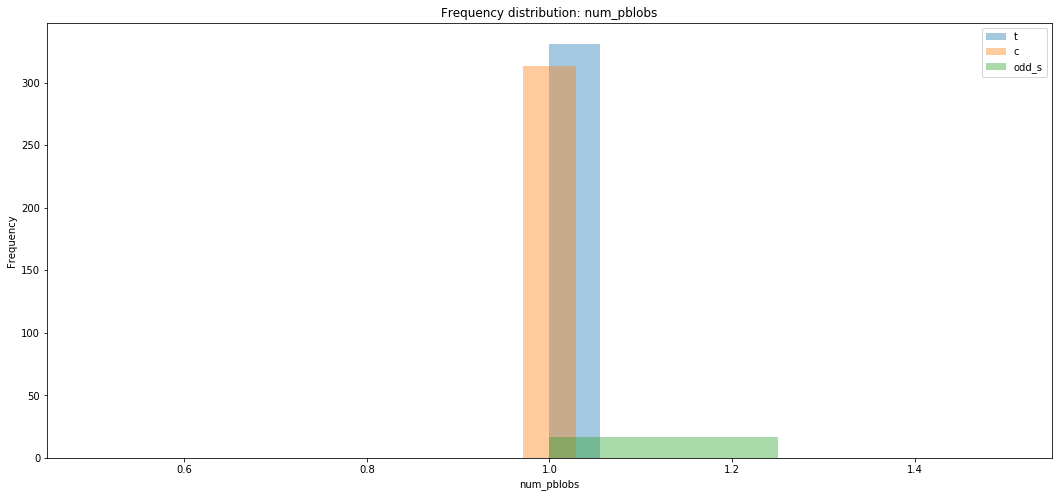

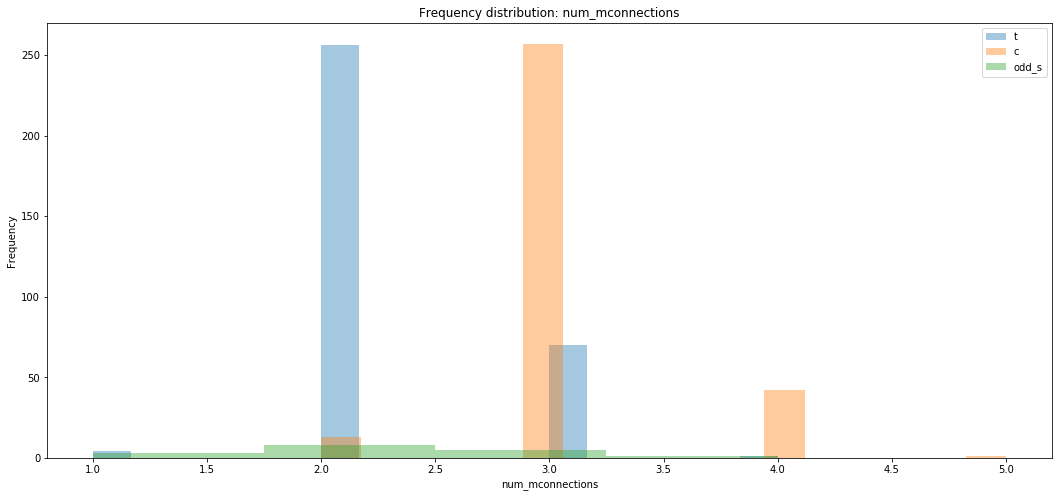

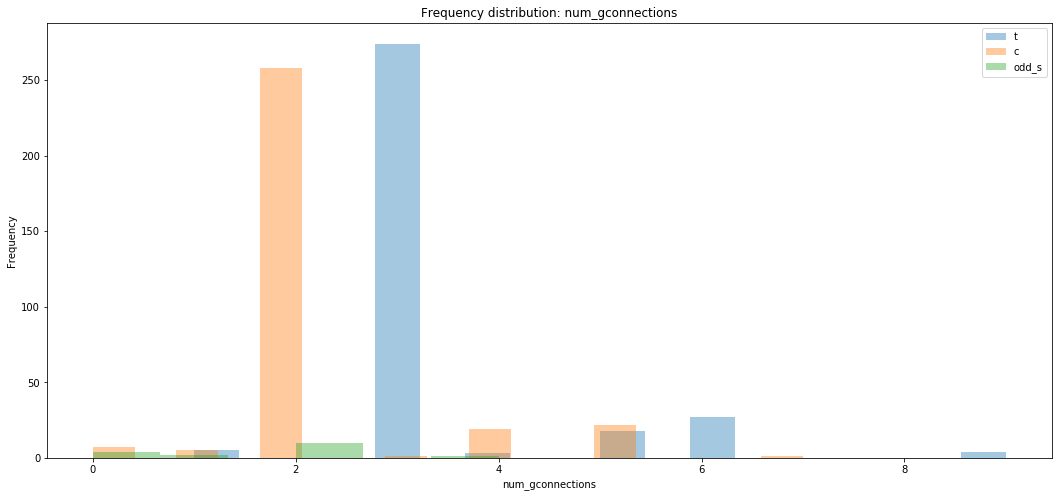

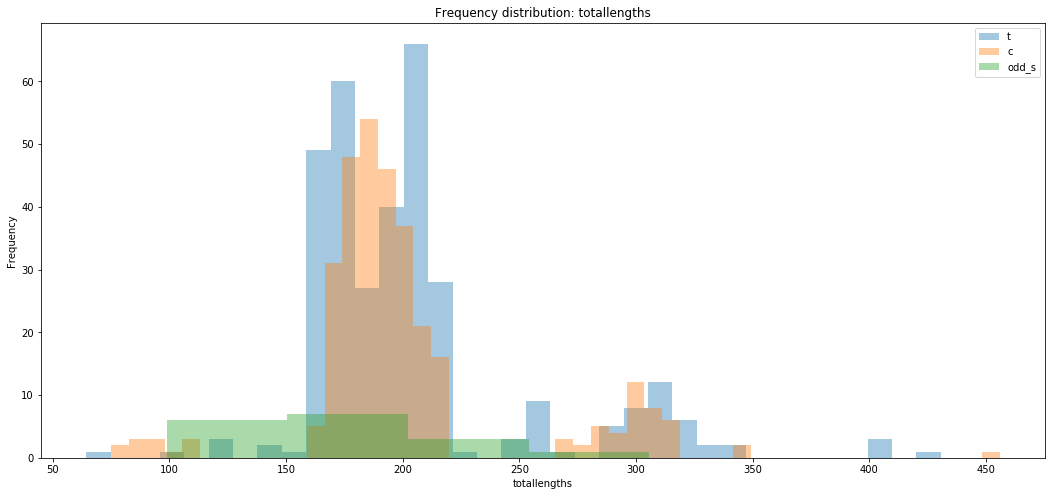

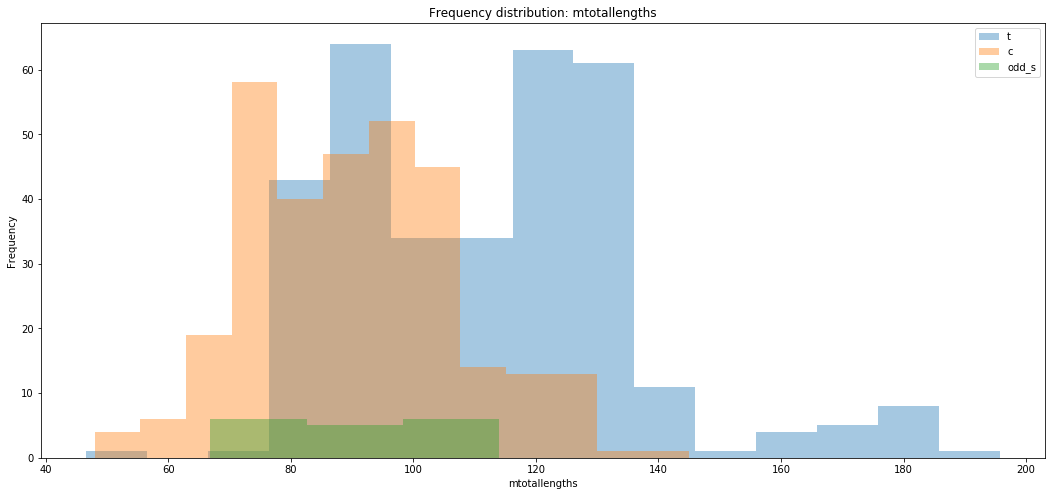

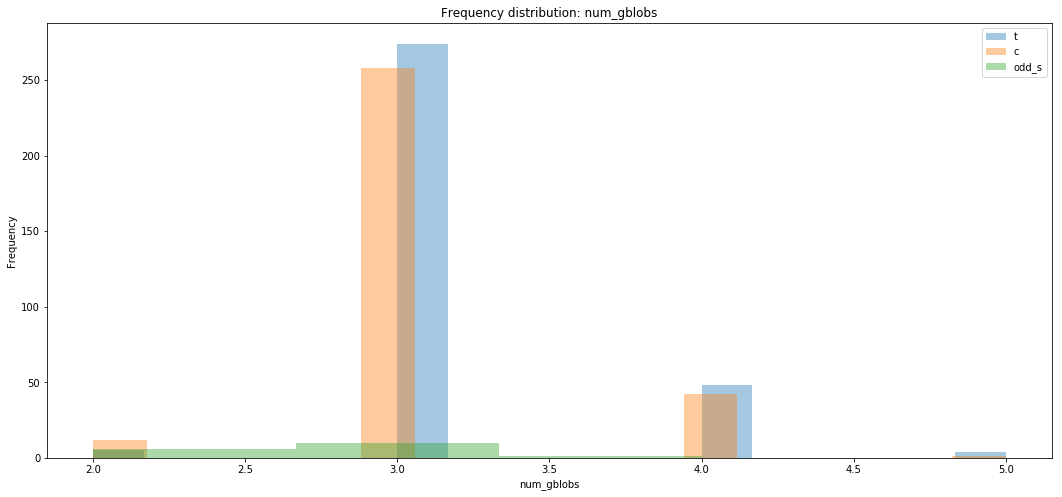

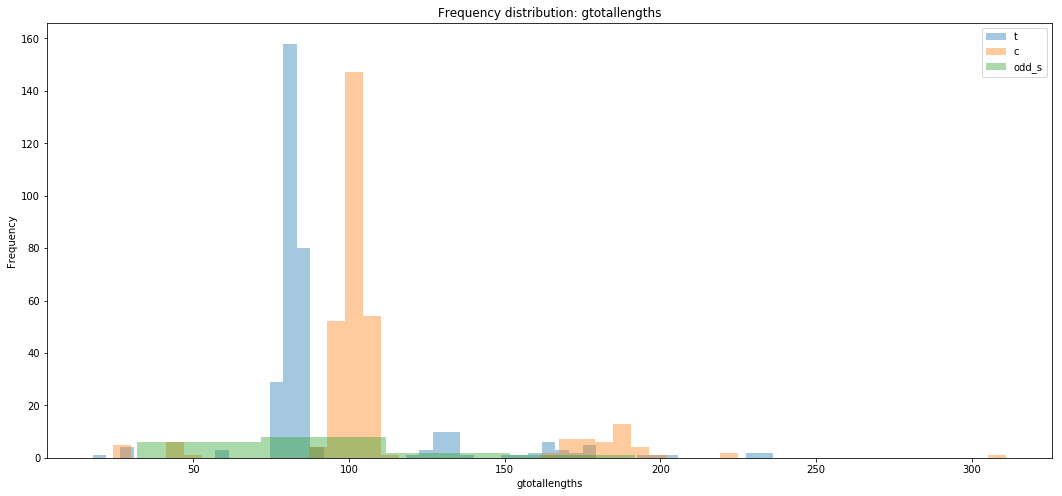

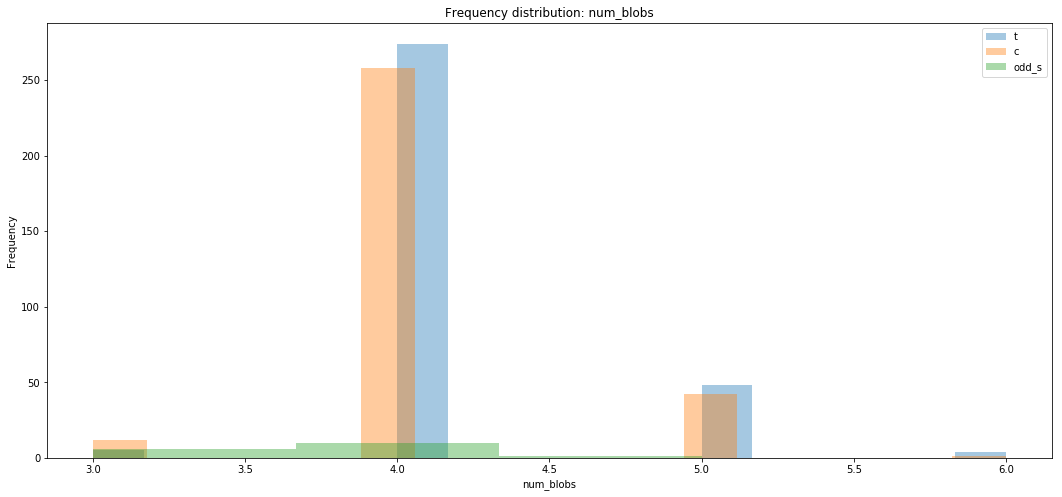

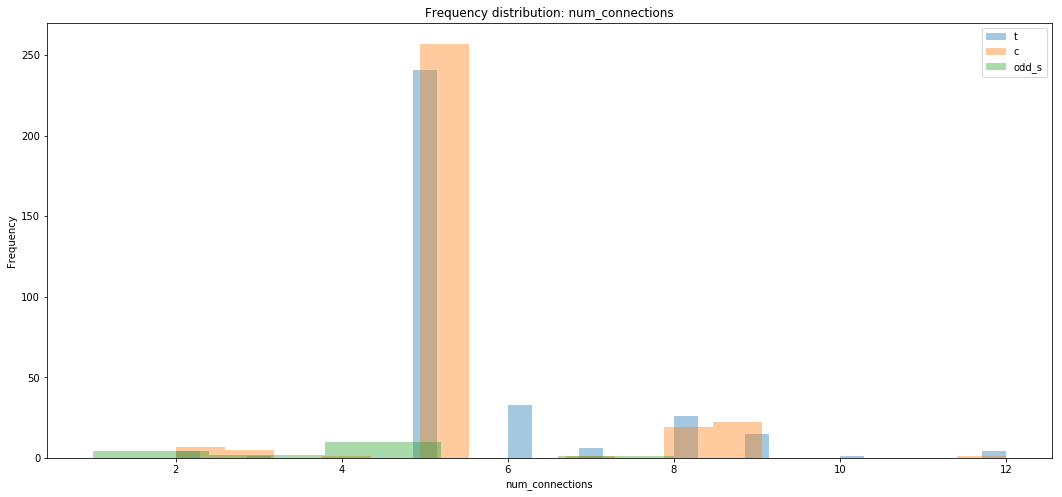

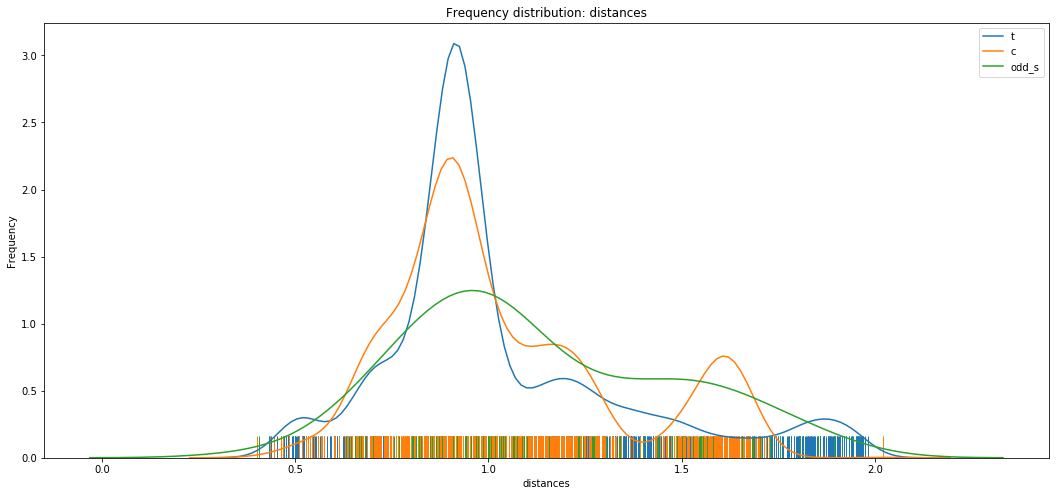

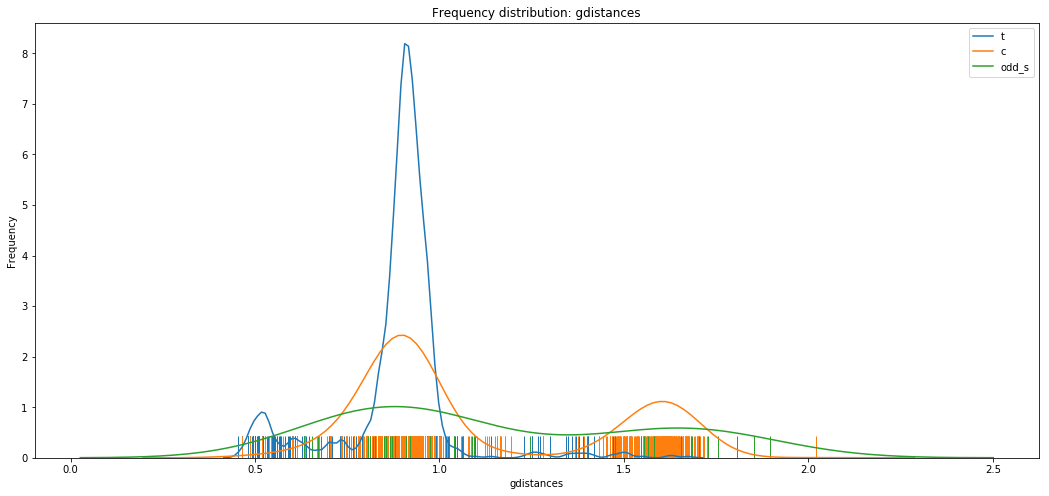

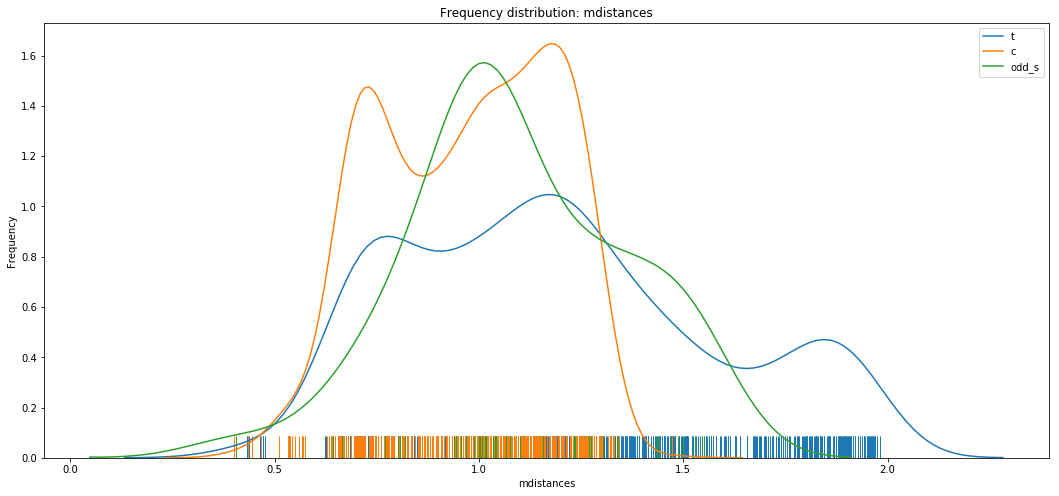

In [10]:
"""Everything"""

# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in a_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




num_pblobs averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
num_pblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_mconnections averages: 
t : 2 
c : 3 
odd_s : 2 
broken : 1 
num_mconnections variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 0 
num_gconnections averages: 
t : 3 
c : 2 
odd_s : 2 
broken : 1 
num_gconnections variances: 
t : 1 
c : 1 
odd_s : 1 
broken : 0 
totallengths averages: 
t : 205 
c : 201 
odd_s : 175 
broken : 440 
totallengths variances: 
t : 2463 
c : 2255 
odd_s : 2734 
broken : 71367 
mtotallengths averages: 
t : 112 
c : 90 
odd_s : 89 
broken : 180 
mtotallengths variances: 
t : 550 
c : 291 
odd_s : 213 
broken : 6081 
num_gblobs averages: 
t : 3 
c : 3 
odd_s : 3 
broken : 3 
num_gblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 1 
gtotallengths averages: 
t : 93 
c : 111 
odd_s : 86 
broken : 259 
gtotallengths variances: 
t : 960 
c : 1147 
odd_s : 1491 
broken : 37420 
num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs varia

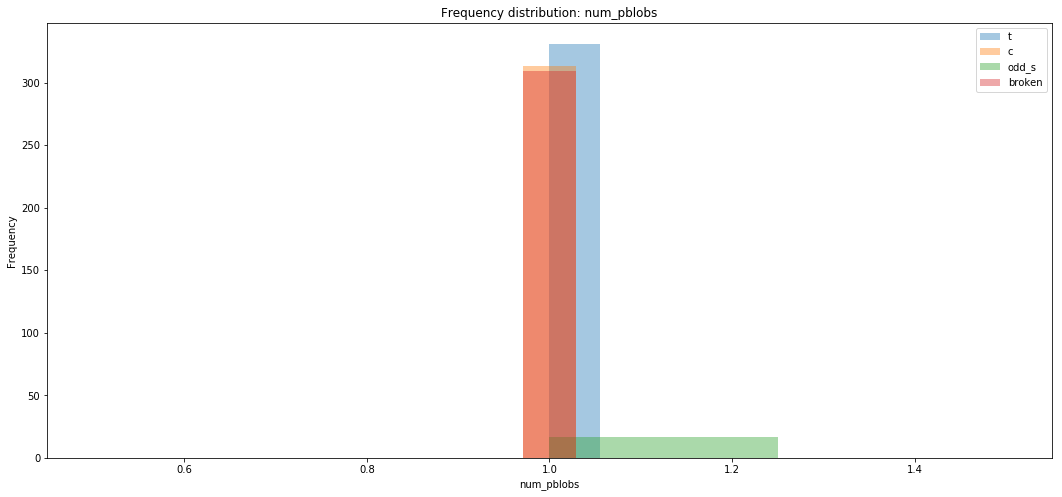

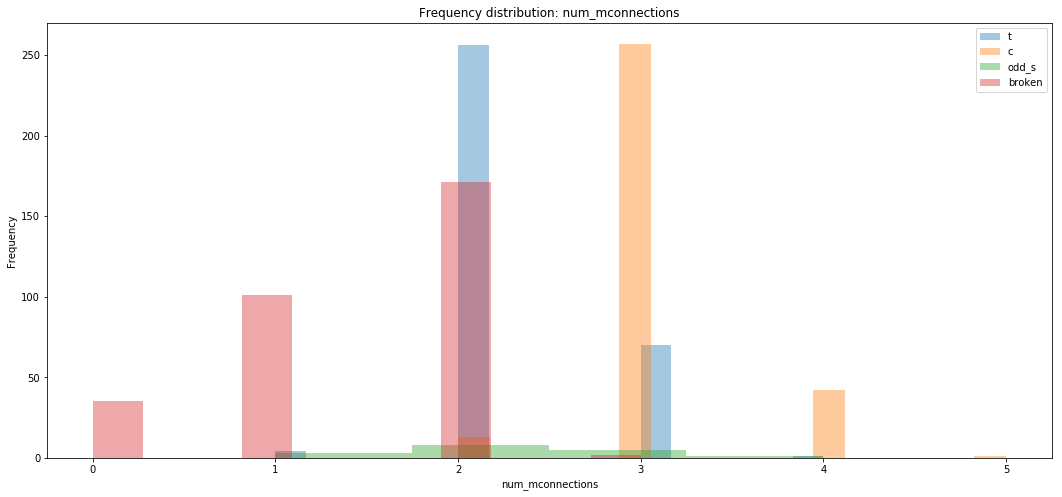

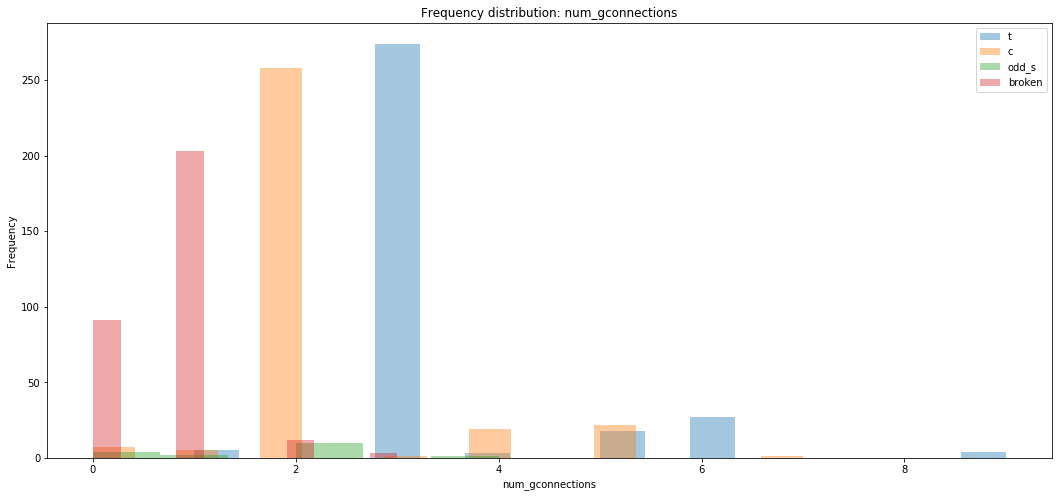

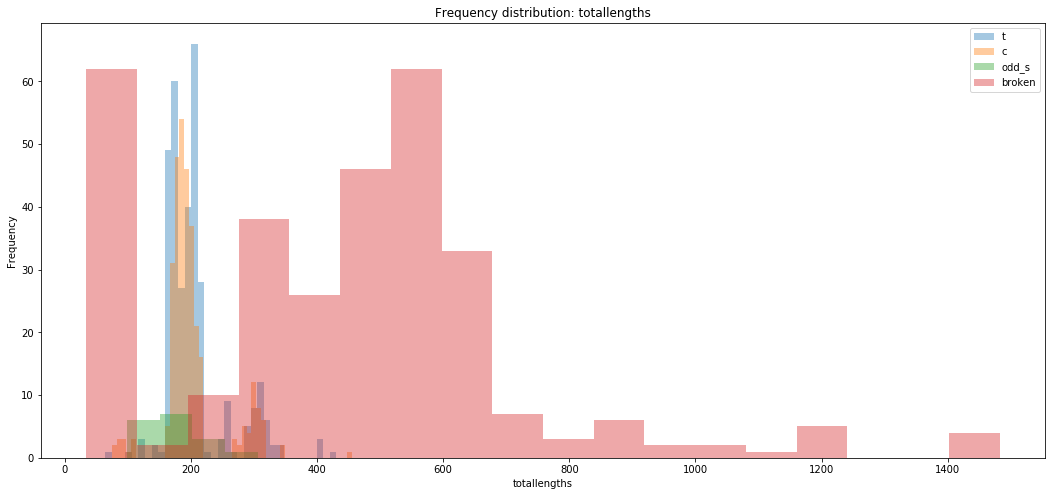

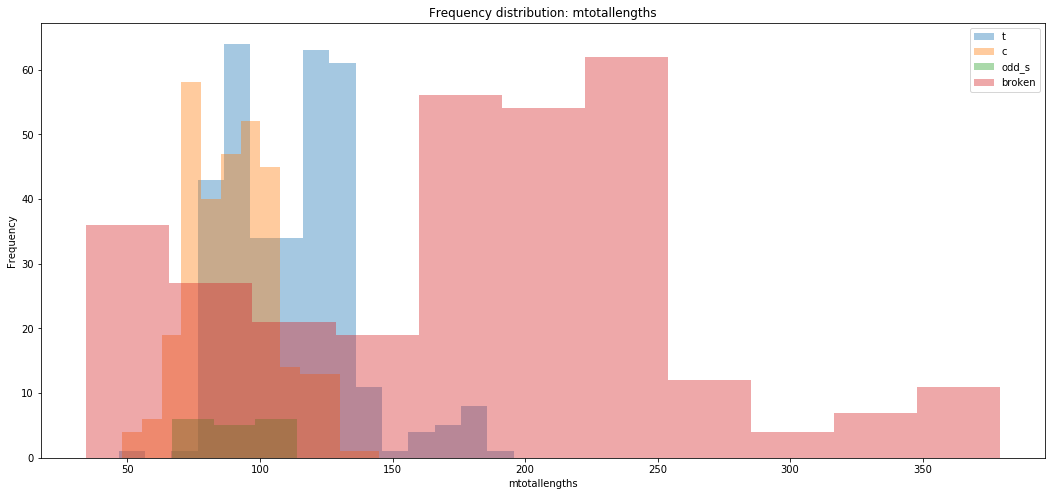

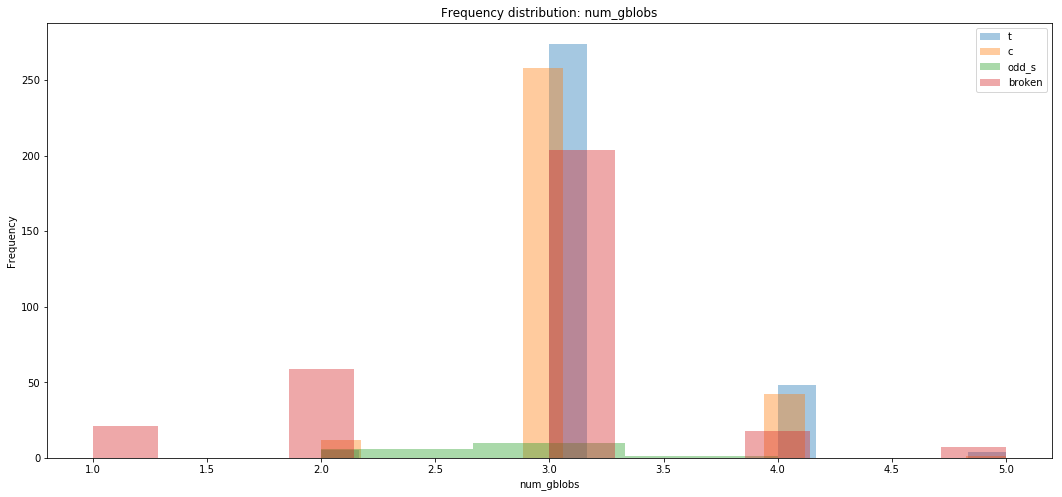

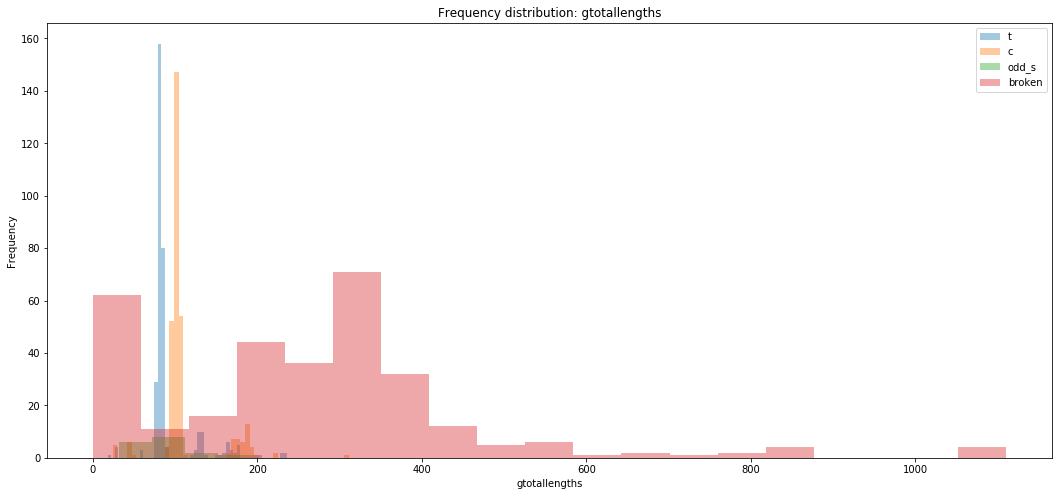

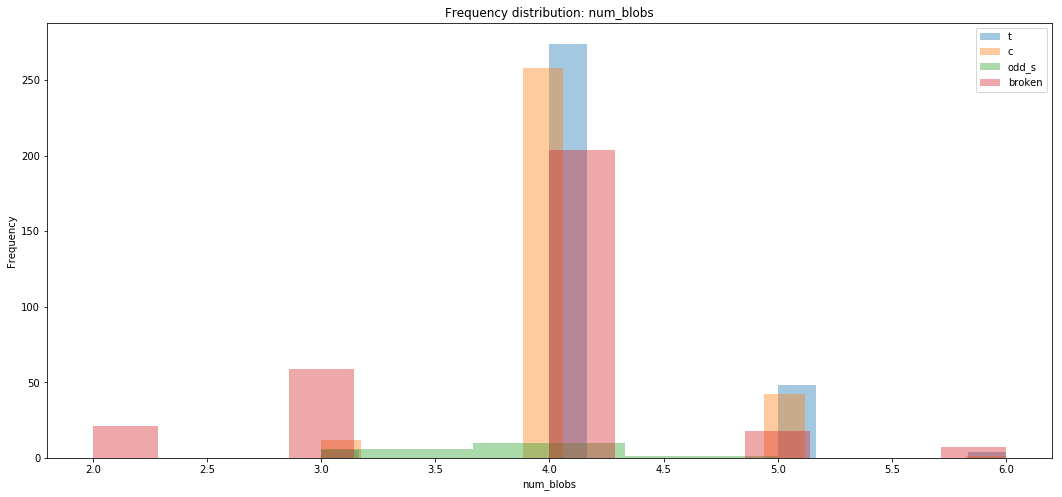

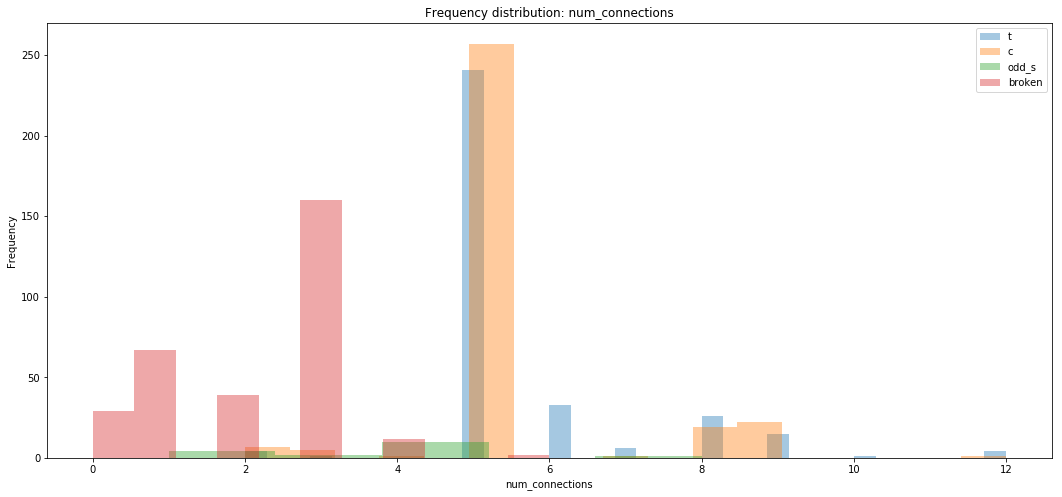

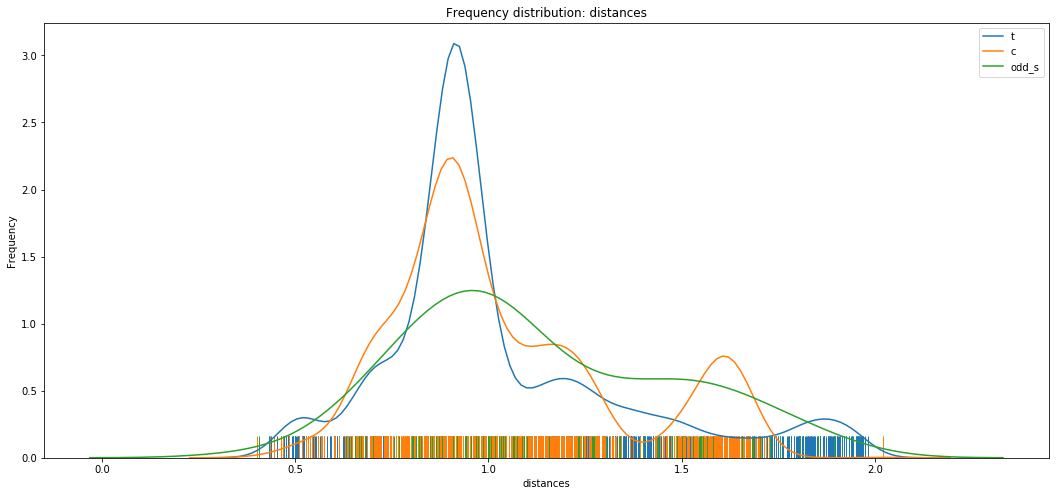

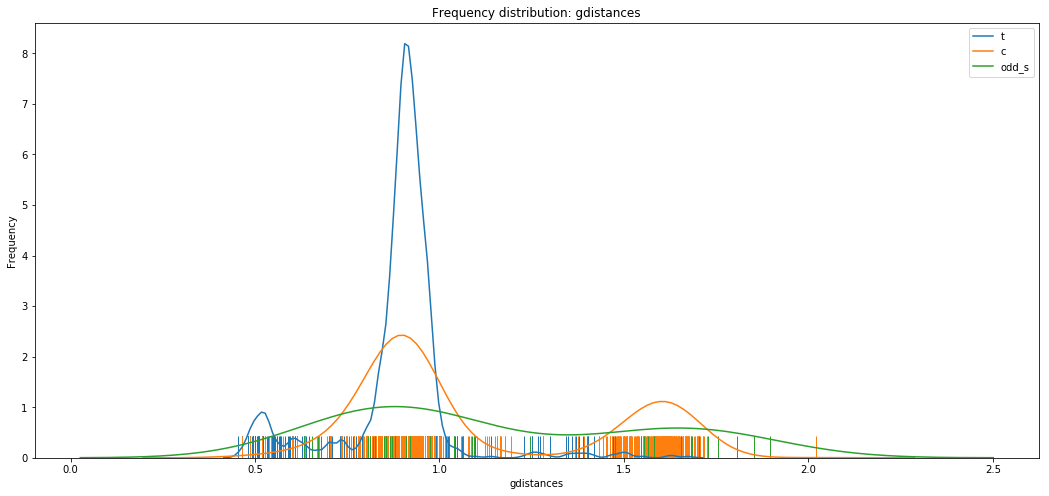

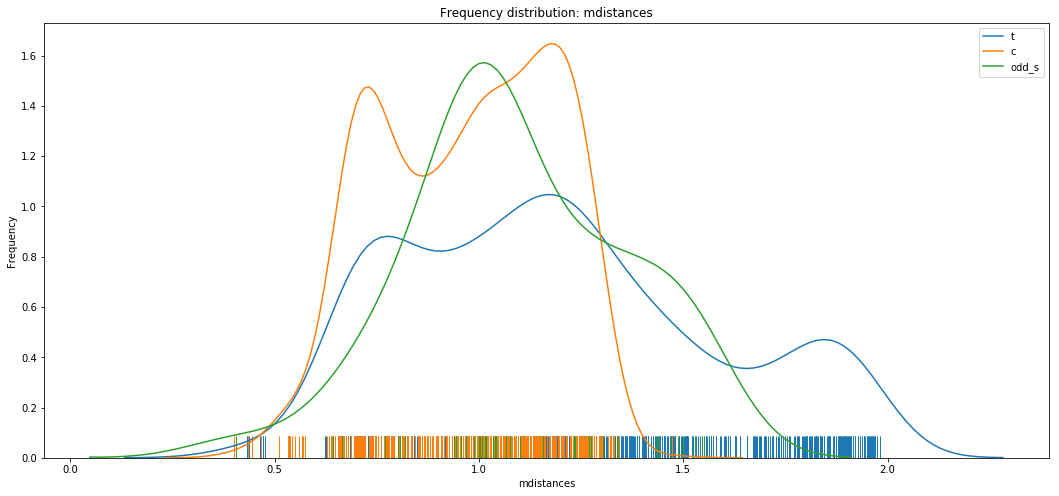

In [11]:
"""After first tests"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in filtrates_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

num_pblobs averages: 
t : 1 
c : 1 
odd_s : 1 
broken : 1 
num_pblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 0 
num_mconnections averages: 
t : 2 
c : 3 
odd_s : 2 
broken : 1 
num_mconnections variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 0 
num_gconnections averages: 
t : 3 
c : 2 
odd_s : 1 
broken : 1 
num_gconnections variances: 
t : 0 
c : 0 
odd_s : 1 
broken : 0 
totallengths averages: 
t : 192 
c : 189 
odd_s : 165 
broken : 440 
totallengths variances: 
t : 285 
c : 167 
odd_s : 3509 
broken : 71367 
mtotallengths averages: 
t : 109 
c : 87 
odd_s : 86 
broken : 180 
mtotallengths variances: 
t : 243 
c : 151 
odd_s : 266 
broken : 6081 
num_gblobs averages: 
t : 3 
c : 3 
odd_s : 3 
broken : 3 
num_gblobs variances: 
t : 0 
c : 0 
odd_s : 0 
broken : 1 
gtotallengths averages: 
t : 82 
c : 102 
odd_s : 79 
broken : 259 
gtotallengths variances: 
t : 10 
c : 15 
odd_s : 1930 
broken : 37420 
num_blobs averages: 
t : 4 
c : 4 
odd_s : 4 
broken : 4 
num_blobs variances:

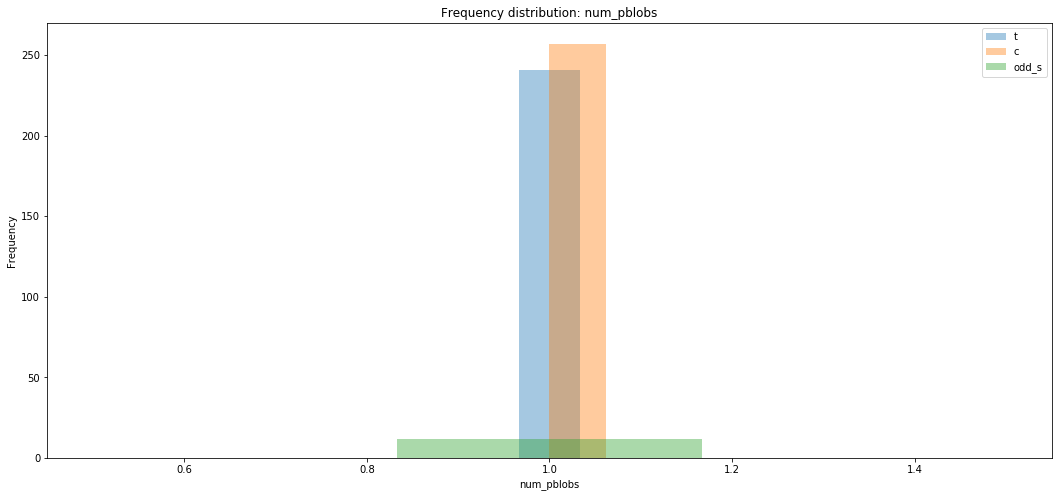

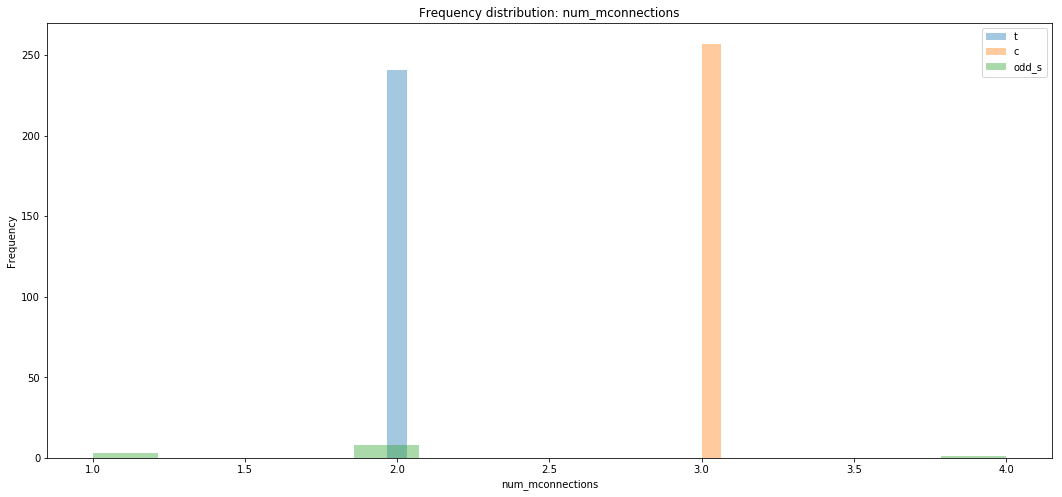

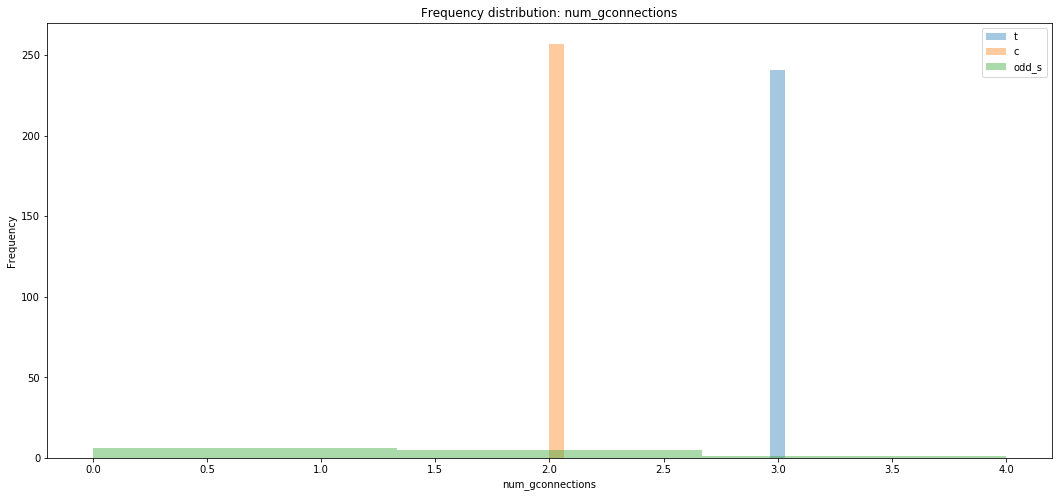

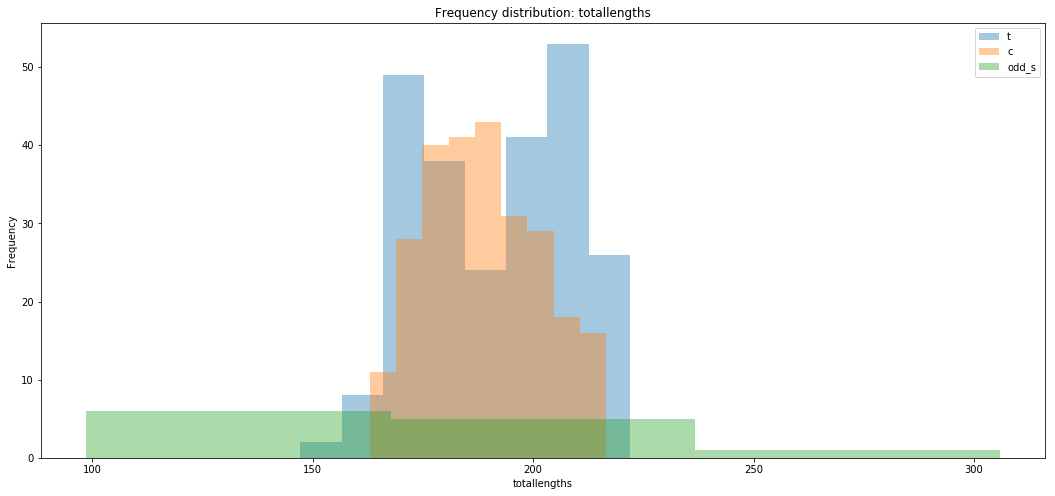

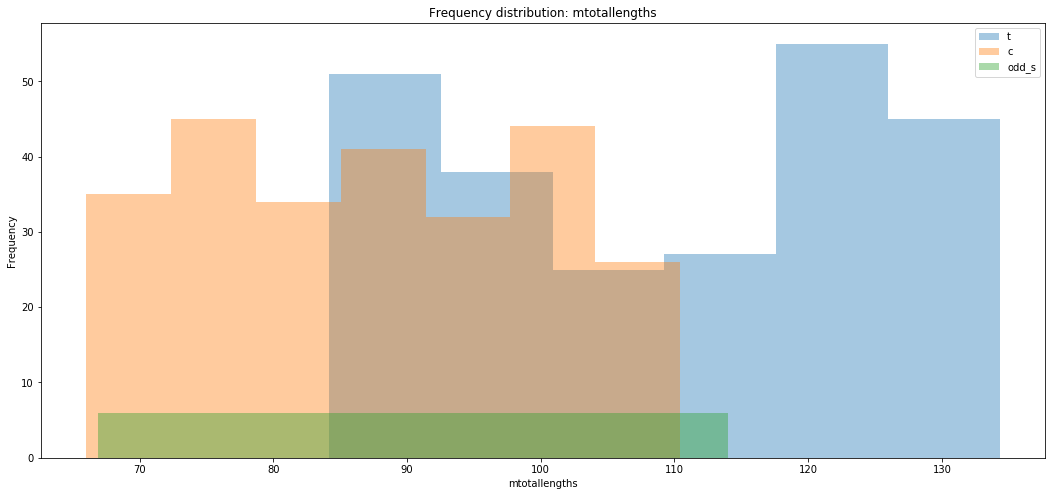

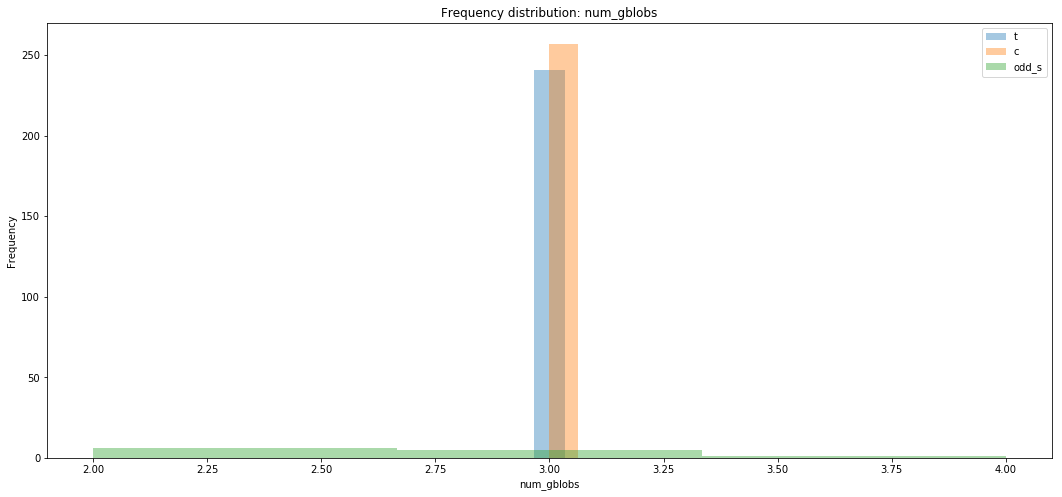

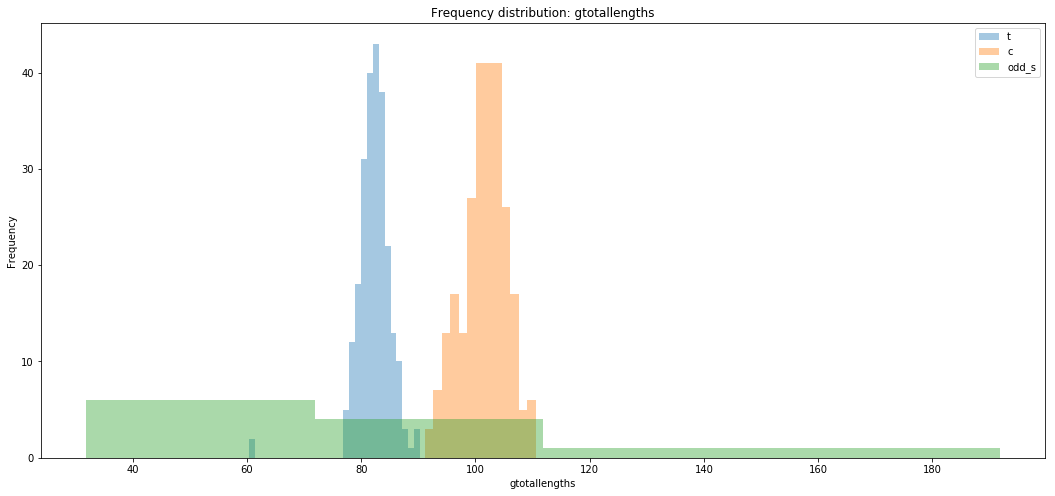

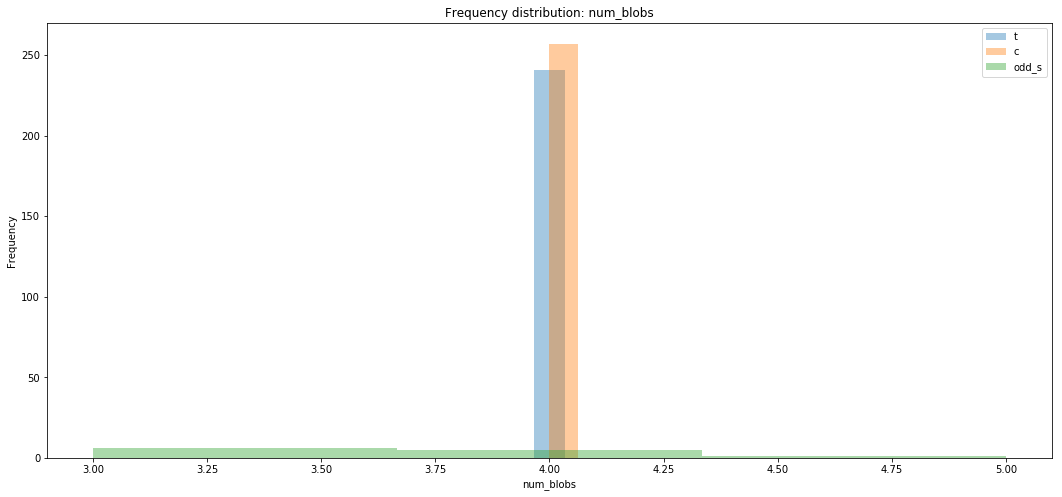

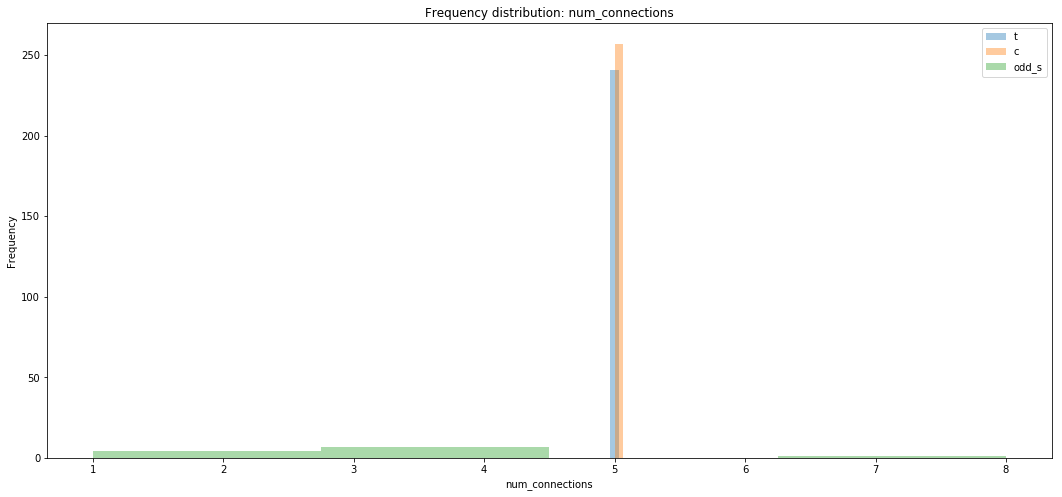

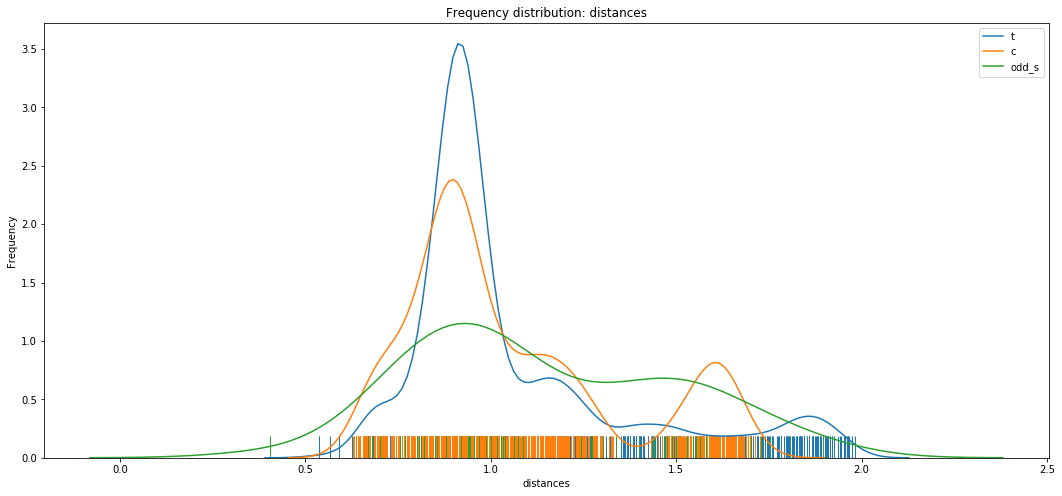

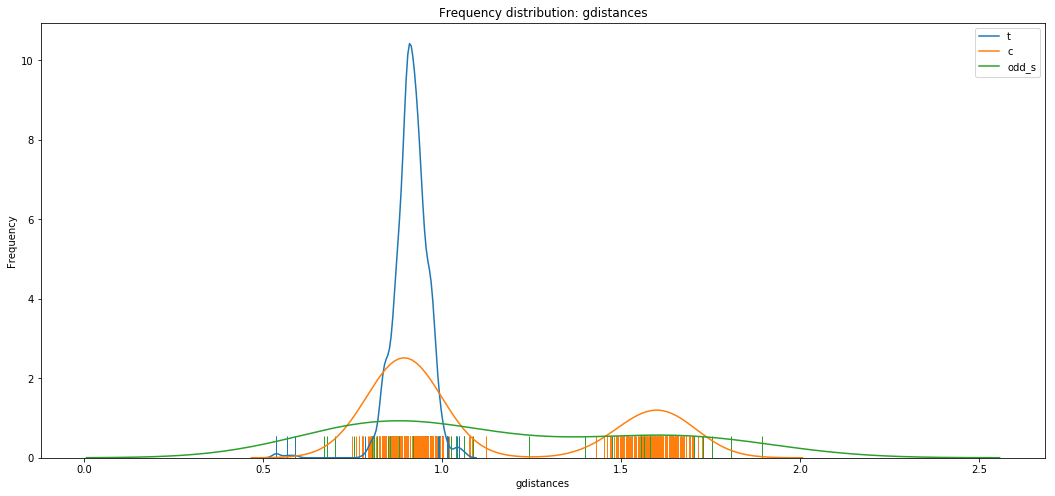

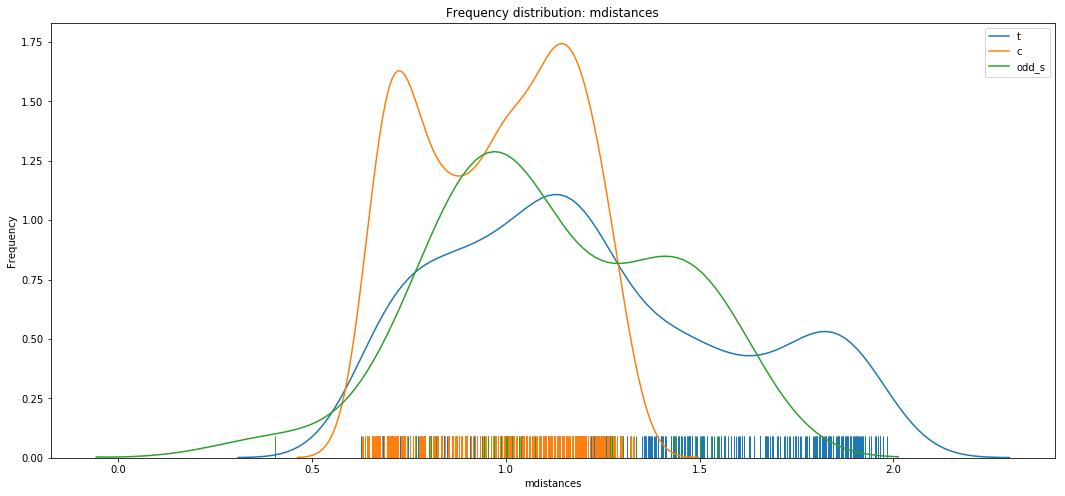

In [12]:

"""Correctly classified"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in passes[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
